In [1]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

import time
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
%matplotlib inline
tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train             = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test              = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks            = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

In [4]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


### 📊 Brief EDA

In [5]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [6]:
summary(train)

data shape: (617, 58)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
Id,object,0,0.000000,617,NaN,NaN,000ff2bfdfe9,007255e47698,013f2bd269f5
AB,float64,0,0.000000,217,0.081187,6.161666,0.209377,0.145282,0.47003
AF,float64,0,0.000000,599,192.59328,28688.18766,3109.03329,978.76416,2635.10654
AH,float64,0,0.000000,227,85.200147,1910.123198,85.200147,85.200147,85.200147
AM,float64,0,0.000000,605,3.177522,630.51823,22.394407,36.968889,32.360553
AR,float64,0,0.000000,130,8.138688,178.943634,8.138688,8.138688,8.138688
AX,float64,0,0.000000,427,0.699861,38.27088,0.699861,3.63219,6.73284
AY,float64,0,0.000000,148,0.025578,10.315851,0.025578,0.025578,0.025578
AZ,float64,0,0.000000,484,3.396778,38.971568,9.812214,13.51779,12.82457
BC,float64,0,0.000000,259,1.2299,1463.693448,5.555634,1.2299,1.2299


### 💡 Summary of EDA:
There are 56 X variables and 1 target(y) variable, while 1 variable(id) is extra data

All variable types are float64, except for the EJ variable which is of type object.

9 variables have missing value. The missing value ratio is not high.

In [7]:
# select numerical and categorical variables respectively.
num_cols = test.select_dtypes(include=['float64']).columns.tolist()
cat_cols = test.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Id')

In [8]:
fig2 = px.pie(train, names='Class', 
             height=400, width=600, 
             hole=0.7, 
             title='target class Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

📊 this is a kind of imbalanced dataset. But not extremely imbalanced one....😁 Personally, I don't think we need over-sampling method in this case...

In [9]:
#for visualization, pick 12 numerical variables.
import random

random_num_cols = random.sample(num_cols, k=12)

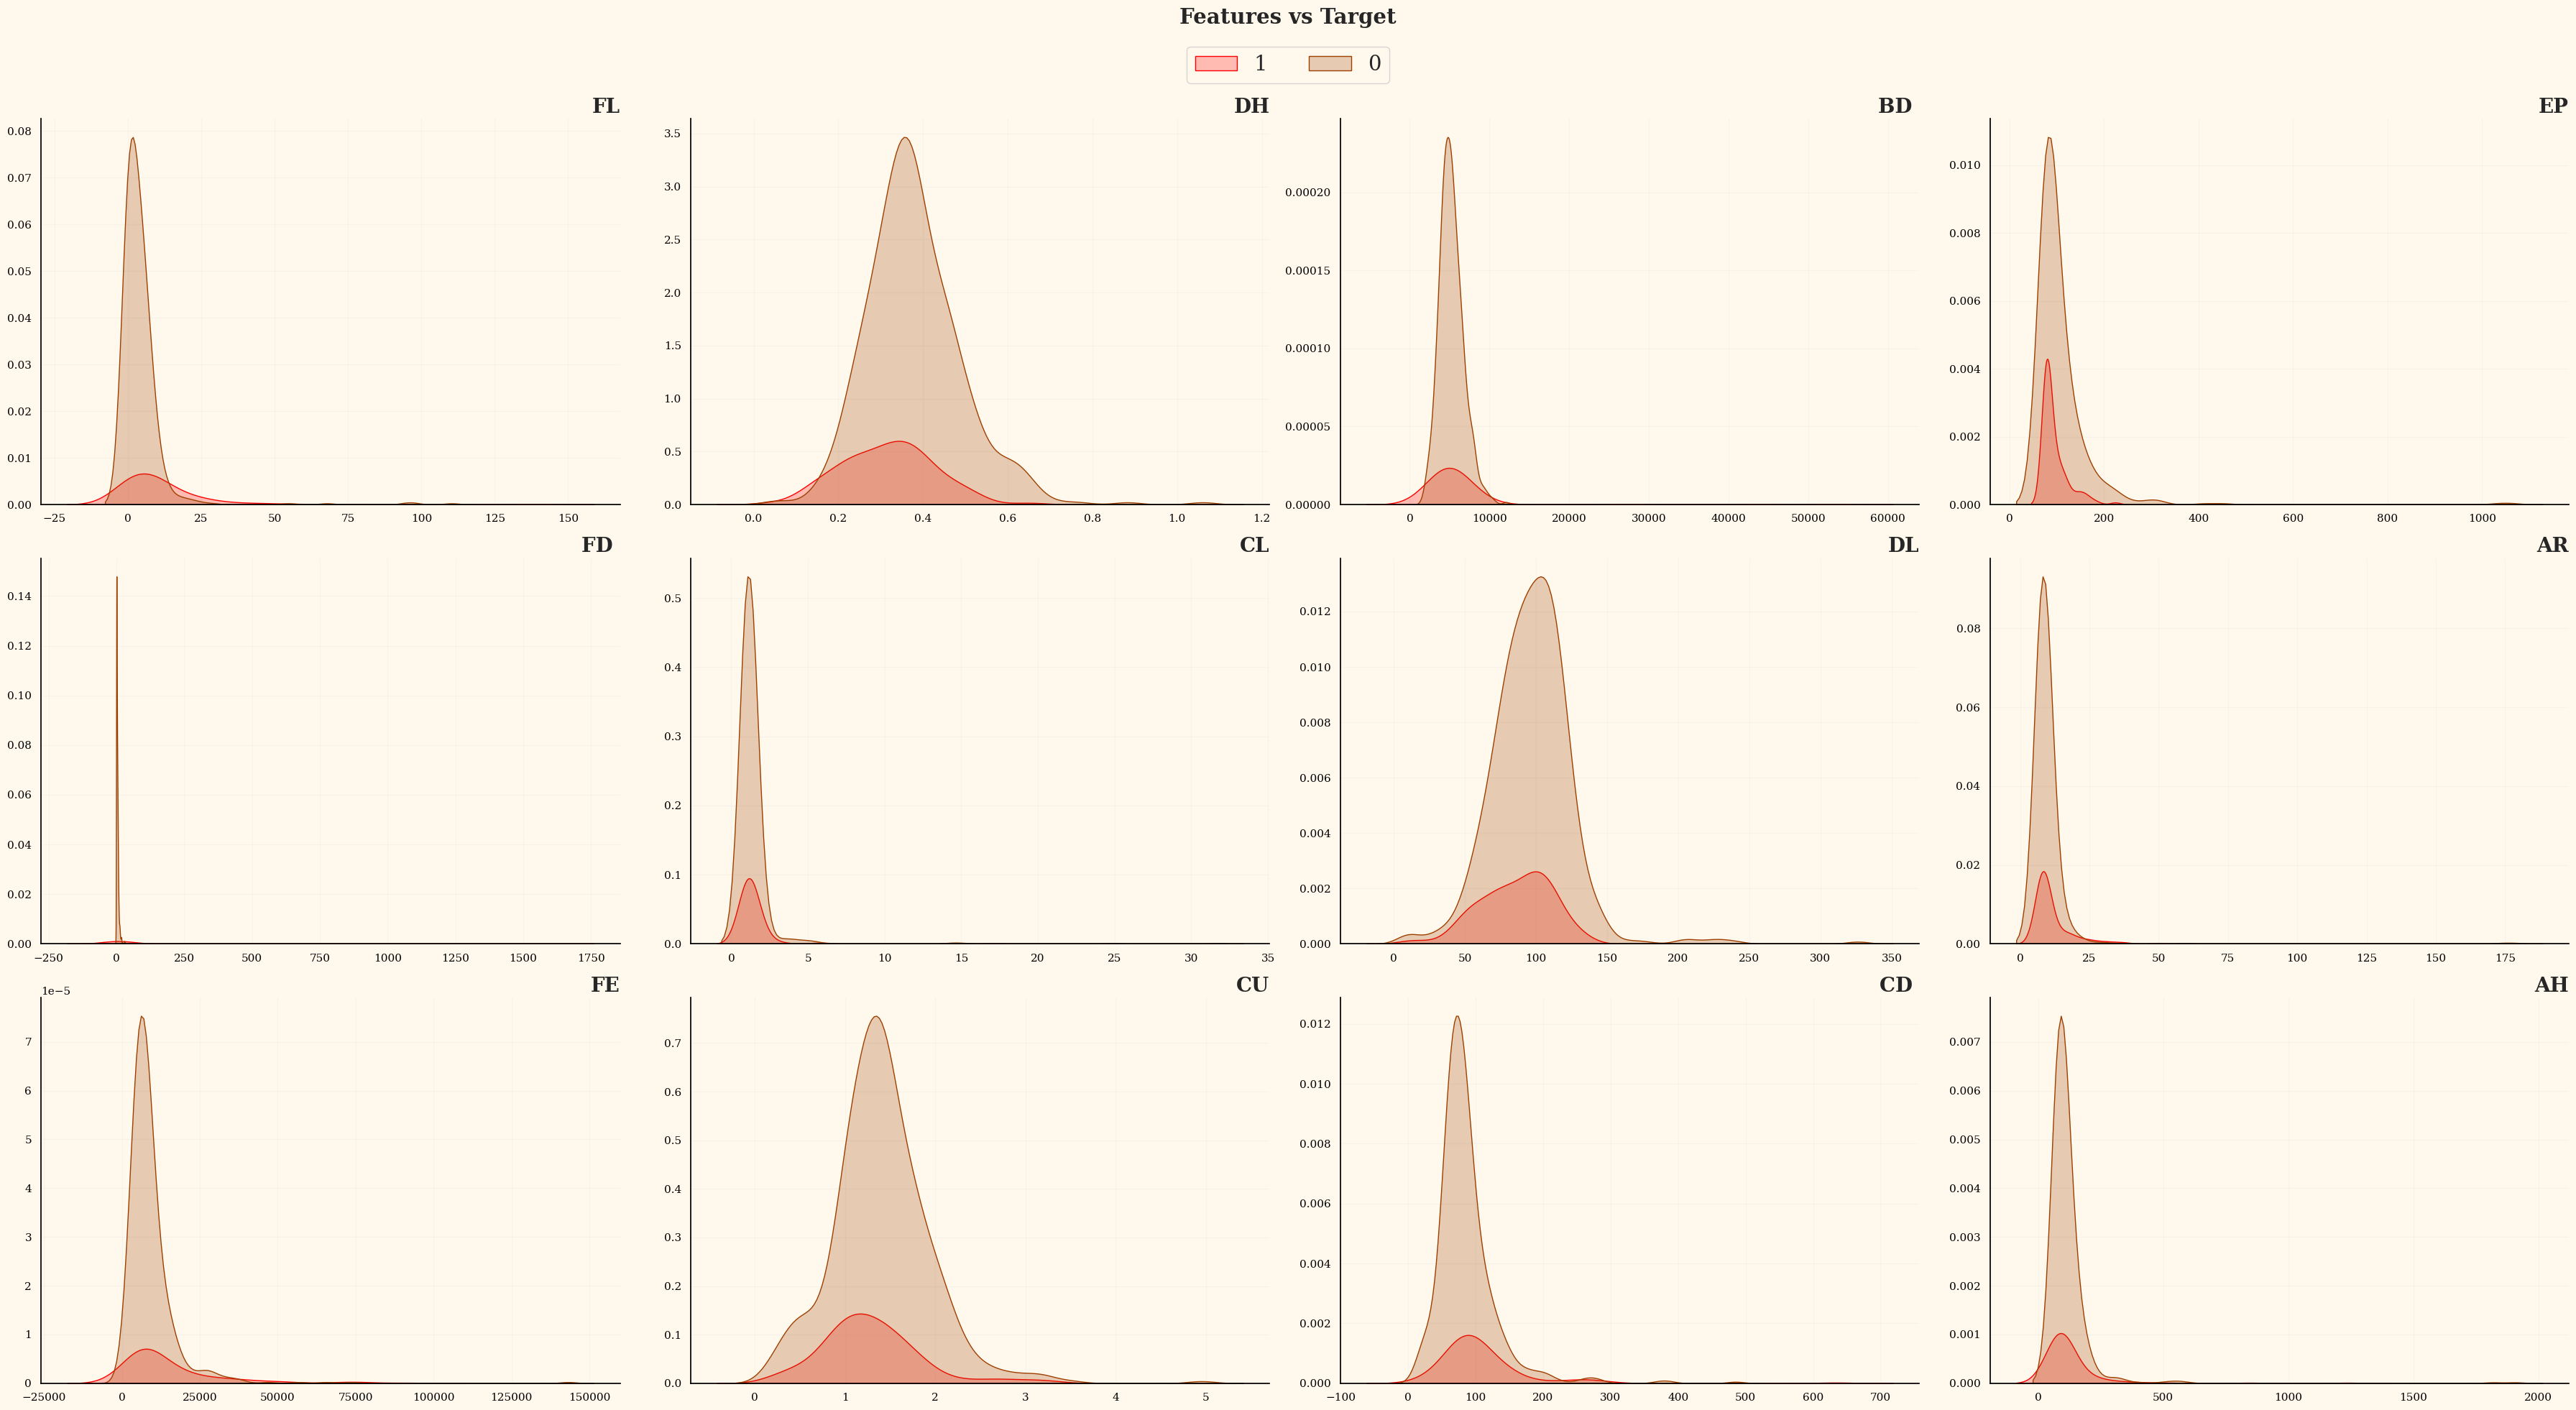

CPU times: user 4.36 s, sys: 218 ms, total: 4.57 s
Wall time: 4.35 s


In [10]:
%%time
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(random_num_cols):
    ax = plt.subplot(3,4, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

### 💡 Insights:
The distribution is different obviously, which means these variables have predictive power in some sense.

However, some variables need to be scaled.

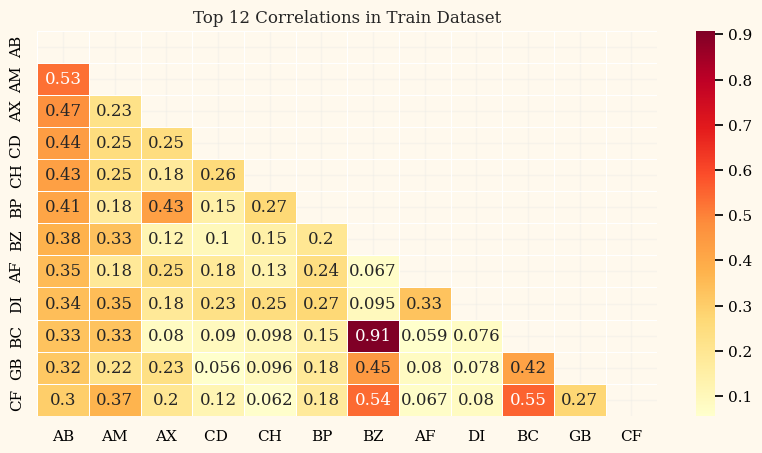

In [11]:
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str='Top Correlations') -> None:
    # Calculate correlation between all variables
    corr = df.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data
plot_top_correlations(train[num_cols], 12, 'Top 12 Correlations in Train Dataset')

### 💡 Insights:
In the above code, n is the number of variables you want to view. top_corr_cols selects the n variables with the largest absolute correlation, and top_corr calculates the correlation matrix of these variables. The heatmap is then plotted using this correlation matrix.

Although certain variables exhibit strong correlations, the overall correlation among the variables is not very high. This is especially considering that all the variables are health-related data.

### 🛠️ Modeling

### 💡 Modeling Overview:
* build baseline model without hyperparameter tuning

* 10-fold cross validation methods are used for baseline modeling.

### 🧱 Preprocessing

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Combine numeric and categorical features
FEATURES = num_cols + cat_cols

# Fill missing values with mean for numeric variables
imputer = SimpleImputer(strategy='mean')
numeric_df = pd.DataFrame(imputer.fit_transform(train[num_cols]), columns=num_cols)

# Scale numeric variables using min-max scaling
scaler = MinMaxScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=num_cols)

# Encode categorical variables using one-hot encoding
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cat_df = pd.DataFrame(encoder.fit_transform(train[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))

# Concatenate the scaled numeric and encoded categorical variables
processed_df = pd.concat([scaled_numeric_df, encoded_cat_df], axis=1)

In [13]:
processed_df.head(5)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,0.021082,0.102347,0.00000,0.030632,0.0,0.000000,0.000000,0.180337,0.002958,0.047364,...,0.000998,0.000866,0.054959,0.000000,0.013846,0.176983,0.362261,0.005425,0.0,1.0
1,0.010541,0.027589,0.00000,0.053864,0.0,0.078048,0.000000,0.284500,0.000000,0.074042,...,0.000000,0.016014,0.039418,0.000000,0.194527,0.274495,0.164135,1.000000,1.0,0.0
2,0.063949,0.085715,0.00000,0.046519,0.0,0.160575,0.000000,0.265013,0.000000,0.067011,...,0.000385,0.036139,0.250424,0.011229,0.095035,0.258994,0.180218,0.008910,0.0,1.0
3,0.028110,0.127285,0.01918,0.117854,0.0,0.079462,0.000000,0.215235,0.000000,0.048203,...,0.000000,0.006925,0.109565,0.006882,0.014475,0.425143,0.470820,0.007039,0.0,1.0
4,0.049192,0.124246,0.00000,0.017417,0.0,0.086300,0.002841,0.000000,0.069008,0.078555,...,0.038597,0.001731,0.093459,0.051588,0.059198,0.500829,0.185841,0.004345,0.0,1.0


### 🧱 model fitting with XGB

In [15]:
from sklearn.utils import class_weight

FOLDS = 10
SEED = 1004
xgb_models = []
xgb_oof = []
f_imp = []

counter = 1
X = processed_df
y = train['Class']

# Calculate the sample weights
weights = class_weight.compute_sample_weight('balanced', y)

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    if (fold + 1)%5 == 0 or (fold + 1) == 1:
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    watchlist = [(X_train, y_train), (X_valid, y_valid)]

    # Apply weights in the XGBClassifier
    model = XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67)
    model.fit(X_train, y_train, sample_weight=weights[train_idx], eval_set=watchlist, early_stopping_rounds=300, verbose=0)

    val_preds = model.predict_proba(X_valid)[:, 1]
    
    # Apply weights in the log_loss
    val_score = log_loss(y_valid, val_preds, sample_weight=weights[val_idx])
    best_iter = model.best_iteration

    idx_pred_target = np.vstack([val_idx,  val_preds, y_valid]).T 
    f_imp.append({i: j for i, j in zip(X.columns, model.feature_importances_)})
    print(f'{" "*20} Log-loss: {val_score:.5f} {" "*6} best iteration: {best_iter}')

    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)

print('*'*45)
print(f'Mean Log-loss: {np.mean([log_loss(item[:, 2], item[:, 1], sample_weight=weights[item[:, 0].astype(int)]) for item in xgb_oof]):.5f}')


######################## Training FOLD 1 ########################
                     Log-loss: 0.12051        best iteration: 516
                     Log-loss: 0.11538        best iteration: 97
                     Log-loss: 0.24206        best iteration: 55
                     Log-loss: 0.33689        best iteration: 36
######################## Training FOLD 5 ########################
                     Log-loss: 0.31084        best iteration: 999
                     Log-loss: 0.22370        best iteration: 915
                     Log-loss: 0.42750        best iteration: 39
                     Log-loss: 0.37424        best iteration: 53
                     Log-loss: 0.14787        best iteration: 595
######################## Training FOLD 10 ########################
                     Log-loss: 0.31833        best iteration: 59
*********************************************
Mean Log-loss: 0.26173


The exact method of calculating "balanced log loss" can vary depending on the problem or dataset. In some cases, weights may be adjusted according to the class ratios, while in others, higher weights may be assigned to samples from minority classes, etc. The code I've provided shows one way to compute weights considering class imbalance using sklearn's compute_sample_weight function, and then applies these weights in the calculation of log loss.

### 👀 Evaluation and Visualization

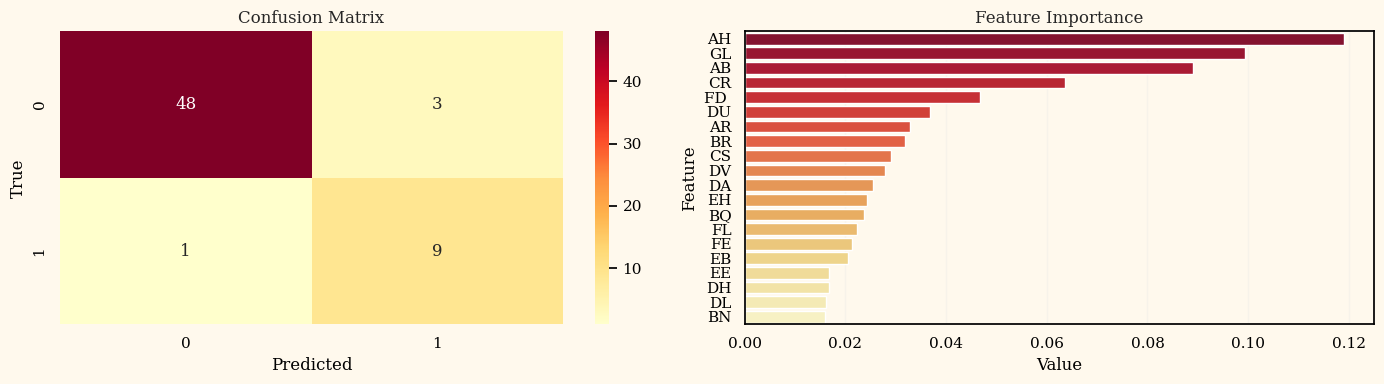

In [16]:
# Confusion Matrix for the last fold
cm = confusion_matrix(y_valid, model.predict(X_valid))

# Feature Importance for the last model
feature_imp = pd.DataFrame({'Value':xgb_models[-1].feature_importances_, 'Feature':X.columns})
feature_imp = feature_imp.sort_values(by="Value", ascending=False)
feature_imp_top20 = feature_imp.iloc[:20]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Subplot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='YlOrRd')
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Subplot 2: Feature Importance
sns.barplot(x="Value", y="Feature", data=feature_imp_top20, ax=ax[1], palette='YlOrRd_r')
ax[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

### 💡 Insights:
* Classification results semes not bad on training set.

* Selected top 20 features from feature importance table and visualized it. please refer to above graph

for those who are not familiar with balanced log-loss....please refer to below AUC graph (just for reference)

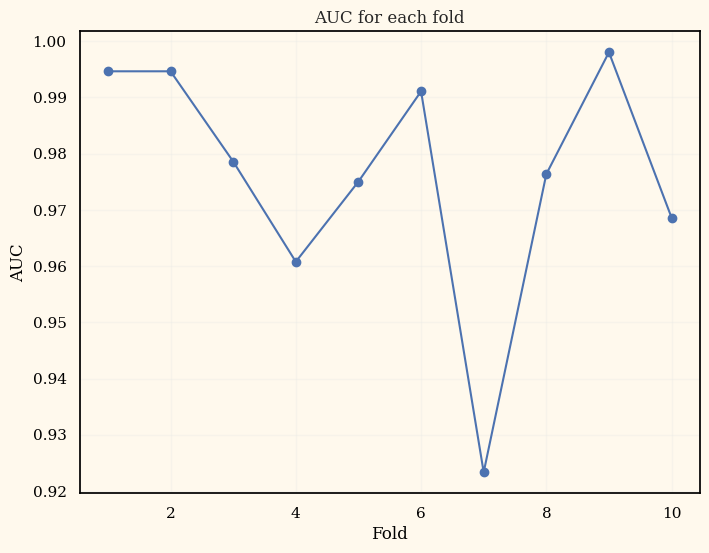

In [17]:
from sklearn.metrics import roc_auc_score

# Compute AUC for each fold
auc_scores = [roc_auc_score(oof[:, 2], oof[:, 1]) for oof in xgb_oof]

# Plot AUC scores
plt.figure(figsize=(8,6))
plt.plot(range(1, FOLDS+1), auc_scores, marker='o')
plt.title('AUC for each fold')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

### 💡 Conclusion:
* This is just a simple baseline code and EDA notebook. There are still room for improvement.

* hyper-paramter tuning, feature selection, feature generation.... you can use these technics to upgrade your model!